In [1]:
# connect Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Drive Connection
import os
os.chdir('/content/drive/My Drive/MNIST/')
!ls

Mounted at /content/drive
Checkpoints


In [2]:
%pwd

'/content/drive/My Drive/MNIST'

In [ ]:
# Import Libraries
import tensorflow as tf
from tensorflow import keras
# More up-to-date versions of Keras
%pip install git+https://github.com/keras-team/keras-preprocessing.git
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

# import MNIST dataset
from tensorflow.keras.datasets import mnist

from sklearn.model_selection import train_test_split
import os, warnings
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [5]:

# Load and preprocess the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize pixel values to be between 0 and 1
y_train, y_test = to_categorical(y_train, 10), to_categorical(y_test, 10)  # One-hot encode labels

# Reshape the data to include a channel dimension (required for Conv2D layers)
#x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
#x_test = x_test.reshape(x_test.shape[0], 28,28, 1)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)


# Create data generators for training and validation sets with autotune
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.shuffle(buffer_size=60000).batch(32).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

validation_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
validation_data = validation_data.batch(32).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)



(60000, 28, 28) (60000, 10) (10000, 28, 28) (10000, 10)


In [6]:

for batch in validation_data.take(1):
  images, labels = batch
  print("Image shape:", images.shape)
  print("Label shape:", labels.shape)



Image shape: (32, 28, 28)
Label shape: (32, 10)


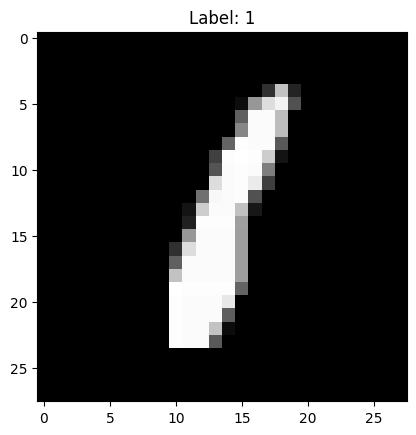

In [7]:

batch = next(iter(train_data))
images, labels = batch
plt.imshow(images[0], cmap='gray')
plt.title(f"Label: {np.argmax(labels[0])}")
plt.show()


In [8]:
# Model
inputs = Input(shape=(28, 28, 1))
x = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs) # output shape: (28, 28, 16)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x) # output shape: (28, 28, 16)
x = BatchNormalization()(x) # output shape: (28, 28, 16)
x = MaxPooling2D((2, 2))(x) # output shape: (14, 14, 16)
x = Dropout(0.2)(x) # output shape: (14, 14, 16)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x) # output shape: (14, 14, 32)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x) # output shape: (14, 14, 32)
x = BatchNormalization()(x) # output shape: (14, 14, 32)
x = MaxPooling2D((2, 2))(x) # output shape: (7, 7, 32)
x = Dropout(0.2)(x) # output shape: (7, 7, 32)

x = Flatten()(x) # output shape: (1568)

x = Dense(128, activation='relu')(x) # output shape: (128)
x = BatchNormalization()(x) # output shape: (128)
x = Dropout(0.2)(x) # output shape: (128)

outputs = Dense(10, activation='softmax')(x) # output shape: (10)


In [9]:
# compile the model
model = Model(inputs, outputs)
model.compile(
   optimizer='adam',
   loss='categorical_crossentropy',
   metrics=['accuracy'])

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 16)        2320      
                                                                 
 batch_normalization (Batch  (None, 28, 28, 16)        64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 16)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 14, 14, 16)        0     

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [23]:
# Define the callbacks

# define the checkpoint directory to store the checkpoints
check_save_dir = '/content/drive/My Drive/MNIST/Checkpoints/'
# if the checkpoint directory does not exist, create it
if not os.path.exists(check_save_dir):
    os.makedirs(check_save_dir)

# define the checkpoint callback
checkpoint = ModelCheckpoint(
    check_save_dir,
    save_weights_only=False,
    save_best_only=True,
    monitor='loss',
    mode='min',
    verbose=1
    )

# define early stopping callback
early_stopping = EarlyStopping(
    monitor='loss', # metric to monitor for early stopping
    patience=3, # number of epochs to wait before stopping
    restore_best_weights=True, # restore the best model weights found during training
)

In [11]:
import tensorflow.keras.backend as K
K.clear_session()

In [25]:
# fit the model
history = model.fit(
   train_data,
   validation_data=validation_data,
   epochs=40,
   initial_epoch=20,
   batch_size=32,
   verbose=1,
   callbacks=[checkpoint, early_stopping]
)

Epoch 21/40
1875/1875 [==============================] - ETA: 0s - loss: 0.0122 - accuracy: 0.9960
Epoch 21: loss improved from inf to 0.01223, saving model to /content/drive/My Drive/MNIST/Checkpoints/
1875/1875 [==============================] - 142s 76ms/step - loss: 0.0122 - accuracy: 0.9960 - val_loss: 0.0156 - val_accuracy: 0.9951
Epoch 22/40
1875/1875 [==============================] - ETA: 0s - loss: 0.0110 - accuracy: 0.9962
Epoch 22: loss improved from 0.01223 to 0.01101, saving model to /content/drive/My Drive/MNIST/Checkpoints/
1875/1875 [==============================] - 129s 69ms/step - loss: 0.0110 - accuracy: 0.9962 - val_loss: 0.0168 - val_accuracy: 0.9948
Epoch 23/40
1875/1875 [==============================] - ETA: 0s - loss: 0.0112 - accuracy: 0.9964
Epoch 23: loss did not improve from 0.01101
1875/1875 [==============================] - 123s 65ms/step - loss: 0.0112 - accuracy: 0.9964 - val_loss: 0.0172 - val_accuracy: 0.9953
Epoch 24/40
1875/1875 [================

In [27]:

model_save_dir = '/content/drive/My Drive/MNIST/Model_1_40E/'
# if the model directory does not exist, create it
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)

# save the model
model.save(model_save_dir)
history_df = pd.DataFrame(history.history)
history_df.to_csv('/content/drive/My Drive/MNIST/Model_1_40E_metrics.csv')


1/1 [==============================] - 0s 60ms/step


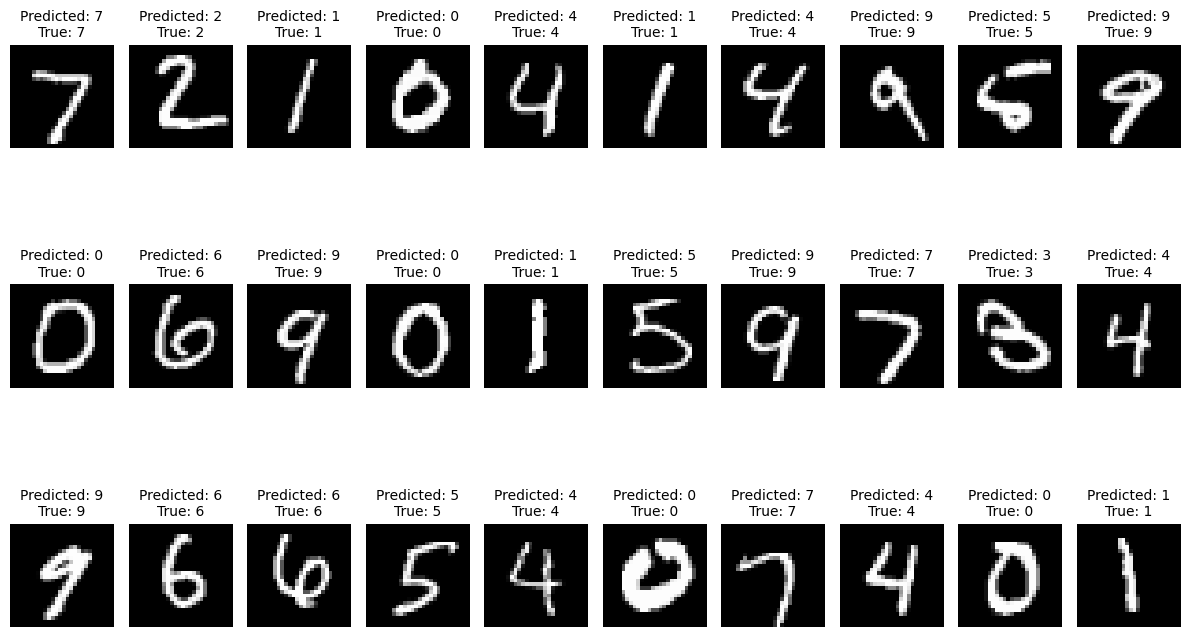

In [30]:
# Get the first 15 images and labels from the validation_data generator
num_images_to_plot = 30
for batch in validation_data.take(1):
    images, labels = batch
    images_to_plot = images[:num_images_to_plot]
    labels_to_plot = labels[:num_images_to_plot]

# Make predictions
predictions = model.predict(images_to_plot)

# Plot the images along with their predictions
plt.figure(figsize=(12, 8))
for i in range(num_images_to_plot):
    plt.subplot(3, 10, i + 1)
    plt.imshow(images_to_plot[i], cmap='gray')
    predicted_label = np.argmax(predictions[i])
    true_label = np.argmax(labels_to_plot[i])
    plt.title(f'Predicted: {predicted_label}\nTrue: {true_label}', fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:

# Get training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

# Find the epoch with the highest validation accuracy
best_epoch = np.argmax(val_accuracy)
best_val_accuracy = val_accuracy[best_epoch]
best_val_loss = val_loss[best_epoch]

# Plot validation loss vs epochs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss) + 1), val_loss, label='Validation Loss', marker='o', alpha=0.5)
plt.scatter(best_epoch + 1, best_val_loss, color='red', label=f'Best: Epoch {best_epoch + 1}\nVal Loss: {best_val_loss:.4f}', zorder=5)
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title('Validation Loss vs Epochs')
plt.legend()
plt.xticks(np.arange(1, len(train_loss) + 1, 1))  # Set x-axis ticks to breaks by 1

# Plot validation accuracy vs epochs
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_loss) + 1), val_accuracy, label='Validation Accuracy', marker='o', alpha=0.5)
plt.scatter(best_epoch + 1, best_val_accuracy, color='red', label=f'Best: Epoch {best_epoch + 1}\nVal Acc: {best_val_accuracy:.4f}', zorder=5)
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs Epochs')
plt.legend()
plt.xticks(np.arange(1, len(train_loss) + 1, 1))  # Set x-axis ticks to breaks by 1

plt.tight_layout()
plt.show()
